In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.signal import convolve2d

générateur d'image

In [3]:
def generate_star_field(image_shape=(256, 256, 3), num_stars=10, star_intensity=(0.5, 1), star_radius=3):
    """
    Génère une image simulant un champ d'étoiles aléatoires.

    Parameters:
    - image_shape: tuple (hauteur, largeur), taille de l'image.
    - num_stars: int, nombre d'étoiles à générer.
    - star_intensity: tuple (min, max), plage d'intensités pour les étoiles (valeurs en niveaux de gris).
    - star_radius: int, rayon des étoiles (en pixels).

    Returns:
    - star_field: numpy array, image du champ d'étoiles.
    """
    # Crée une image noire
    star_field = np.zeros(image_shape, dtype=np.float32)

    # Génère des positions aléatoires pour les étoiles
    height, width = image_shape[:2]
    star_positions = np.random.randint(0, min(height, width), size=(num_stars, 2))

    # Ajoute des étoiles au champ
    for pos in star_positions:
        y, x = pos
        # Ajuste l'intensité et applique un rayon (disque 2D)
        intensity = np.random.uniform(star_intensity[0], star_intensity[1])
        y_coords, x_coords = np.ogrid[:height, :width]
        distance = np.sqrt((y_coords - y)**2 + (x_coords - x)**2)
        star_field[distance <= star_radius] += intensity

    # Clip pour rester dans des valeurs valides
    star_field = np.clip(star_field, 0, 255)

    return star_field, star_positions

Générateur de PSF gaussiennes

In [22]:
def gaussian_ker(size, angle=0, magnitude=1, eccentricity=1, cov=None):
    """
    Génère un noyau gaussien 2D de taille size avec une orientation, une magnitude et une excentricité.

    Parameters:
    - Si on indique la matrice de cov, les autres parametres sont inutiles
    - angle: float, angle de l'ellipse en radians.
    - magnitude: float, longueur de l'axe majeur.
    - eccentricity: float, rapport des longueurs de l'axe mineur à l'axe majeur.
    - size: int, taille du noyau (doit être impair).

    Returns:
    - kernel: numpy array, noyau gaussien 2D de taille size.
    """
    assert size % 2 == 1, "La taille du noyau doit être impaire."
    
    if cov is None:
        # Longueurs des demi-axes
        a = magnitude / 2
        b = a / eccentricity
        
        # Matrice de rotation
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
        
        # Matrice de covariance
        D = np.diag([a**2, b**2])
        cov = R.T @ D @ R
        
    x = np.arange(-(size // 2), size // 2 + 1)
    y = np.arange(-(size // 2), size // 2 + 1)
    x, y = np.meshgrid(x, y)
    pos = np.dstack((x, y))
    
    kernel = np.exp(-0.5 * np.einsum('...k,kl,...l->...', pos, np.linalg.inv(cov), pos))
    kernel /= kernel.sum()
    return kernel


# Exemple d'utilisation
size = 255  # Taille du noyau

psf0 = gaussian_ker(size, 0, 10, 1)
psf1 = gaussian_ker(size, 0, 20, 2)
psf2 = gaussian_ker(size, np.pi/3, 50, 5)

Floutage uniforme

In [23]:
def blur_image(image, psf, mode = "same"):
   output = image.copy()
   if len(image.shape) == 3:
    for i in range(3):
       output[:,:,i] = convolve2d(image[:,:,i], psf, mode=mode)
   else:
       output = convolve2d(image, psf, mode=mode)
   
   return output

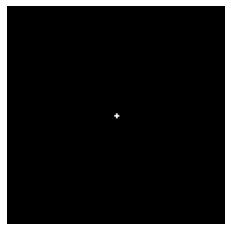

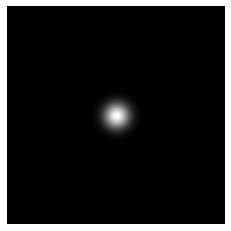

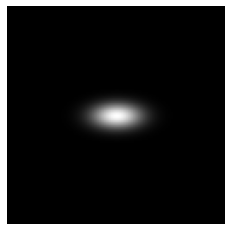

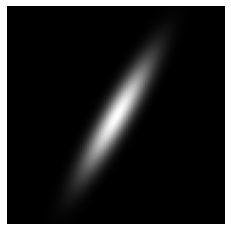

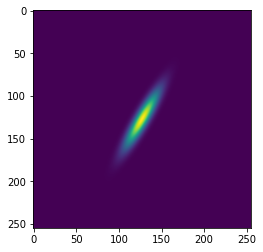

In [24]:
#visualisation des différentes psf sur une étoile isolée


taille_test = 128
image_test_support = np.zeros((taille_test, taille_test))
image_cercle = cv2.circle(image_test_support, (taille_test//2, taille_test//2), 1, 1, -1)
plt.imshow(image_cercle, cmap='gray')
plt.axis("off")
plt.show()

image_cercle0 = blur_image(image_cercle, psf0)
plt.imshow(image_cercle0, cmap='gray')
plt.axis("off")
plt.show()


image_cercle1 = blur_image(image_cercle, psf1)
plt.imshow(image_cercle1, cmap='gray')
plt.axis("off")
plt.show()

image_cercle2 = blur_image(image_cercle, psf2)
plt.imshow(image_cercle2, cmap='gray')
plt.axis("off")

plt.show()
plt.imshow(psf2)
plt.show()

#### Estimateur de la PSF gaussienne (paramteres AME)

In [71]:
from skimage.measure import moments, moments_central
from scipy import ndimage

def estimate_gaussian_params(blurred_image, cov = False):
    """
    Estime les paramètres du noyau gaussien à partir d'une image floue.
    Si mode = cov, renvoie la matrice de cov sinon
    Retourne angle, magnitude, eccentricité
    
    Attention : dans une image, la 1ère dimension correspond à y (lignes) et la 2ème à x (colonnes).
    """
    # Calculer les moments centraux d'ordre 2
    Mc = moments_central(blurred_image) 
    # plotter l'erreur 
    # On suppose que Mc[i, j] = E[(y - y_center)^i (x - x_center)^j]
    # Ainsi, la variance en x (horizontal) est donnée par Mc[0, 2] et celle en y par Mc[2, 0]
    
    mu_xx = Mc[0, 2] / Mc[0, 0]  # variance selon x
    mu_yy = Mc[2, 0] / Mc[0, 0]  # variance selon y
    mu_xy = Mc[1, 1] / Mc[0, 0]  # covariance
    
    if cov:
        return np.array([[mu_xx, mu_xy], [mu_xy, mu_yy]])

    temp = np.sqrt((mu_xx - mu_yy)**2 + 4 * mu_xy**2)
    lambda_major = (mu_xx + mu_yy + temp) / 2  # plus grande valeur propre
    lambda_minor = (mu_xx + mu_yy - temp) / 2  # plus petite valeur propre
    
    # Calcul de l'angle : orientation de l'axe majeur par rapport à l'axe x
    angle = 0.5 * np.arctan2(2 * mu_xy, mu_xx - mu_yy)
    
    # Récupérer les écart-types le long des axes principaux
    sigma_major = np.sqrt(lambda_major)
    sigma_minor = np.sqrt(lambda_minor)
    
    # D'après la construction, magnitude = 2*a avec a = sigma_major
    magnitude = 2 * sigma_major
    
    # Eccentricity = b / a = sigma_minor / sigma_major
    eccentricity = sigma_minor / sigma_major if sigma_major != 0 else 0
    
    return angle, magnitude*eccentricity, 1/eccentricity #EDIT : recorrigé pour les bonnes conventions


# Test sur les images floues plus haut
angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle0)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : 0, 10, 1')
print(estimate_gaussian_params(psf0))


print('-------------------------------------------')

angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle1)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : 0, 5, 2')
print(estimate_gaussian_params(psf1))

print('-------------------------------------------')

angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle2)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : pi/3, 10, 5')
print(estimate_gaussian_params(psf2))


print('-------------------------------------------')

psf3 = gaussian_ker(size, np.pi/4, 3, 8)
image_cercle3 = blur_image(image_cercle, psf3)
angle, magnitude, eccentricity = estimate_gaussian_params(image_cercle3)
print(f"Angle estimé: {angle/np.pi:.2f} pi")
print(f"Magnitude estimée: {magnitude:.2f}")
print(f"Excentricité estimée: {eccentricity:.2f}")
print('Vrai résultat : pi/4, 3, 8')



Angle estimé: -0.12 pi
Magnitude estimée: 10.08
Excentricité estimée: 1.00
Vrai résultat : 0, 10, 1
(-0.39269908169872425, 9.99999999999876, 1.0000000000001028)
-------------------------------------------
Angle estimé: 0.50 pi
Magnitude estimée: 5.16
Excentricité estimée: 1.95
Vrai résultat : 0, 5, 2
(1.5707963267947995, 4.999999999999273, 2.000000000000364)
-------------------------------------------
Angle estimé: -0.17 pi
Magnitude estimée: 10.08
Excentricité estimée: 4.89
Vrai résultat : pi/3, 10, 5
(-0.5235987796891222, 9.999999988661694, 4.99999958053759)
-------------------------------------------
Angle estimé: -0.25 pi
Magnitude estimée: 3.26
Excentricité estimée: 7.38
Vrai résultat : pi/4, 3, 8


voir si y'a assez d'etoiles isolées

Test sur un champ d'étoiles généré

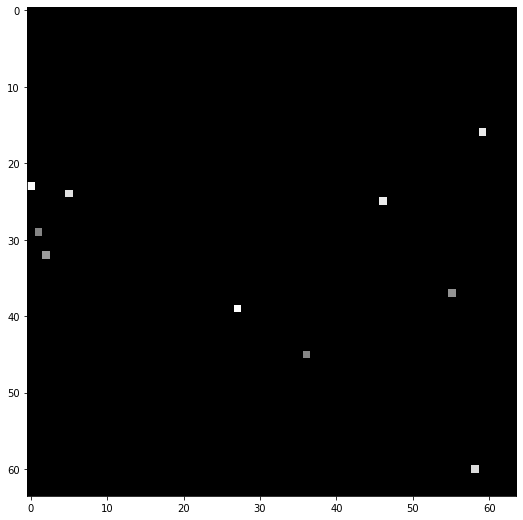

In [52]:
star_field, star_pos = generate_star_field(image_shape= (64,64), num_stars= 10, star_radius=0)

# Affichage de l'image
plt.figure(figsize=(9, 9))
plt.imshow(star_field, cmap='gray')
plt.show()

Convolution spatialement variante:  
kernels sera un tableau de shape [img_h, img_w, ker_h, ker_w] tel que kernels[i,j]
est le noyau de convolution au pixel i,j

In [53]:
def spatially_variant_convolution(image, kernels):
    img_h, img_w = image.shape
    ker_h, ker_w = kernels.shape[2], kernels.shape[3]
    pad_h, pad_w = ker_h // 2, ker_w // 2

    # Pad the image
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    # Extract patches: shape (img_h, img_w, ker_h, ker_w)
    shape = (img_h, img_w, ker_h, ker_w)
    strides = padded_image.strides[:2] + padded_image.strides[:2]
    patches = np.lib.stride_tricks.as_strided(padded_image, shape=shape, strides=strides)

    # Perform element-wise multiplication and summation
    output = np.einsum('ijkl,ijkl->ij', patches, kernels)

    return output

Blur constant pour tester

KeyboardInterrupt: 

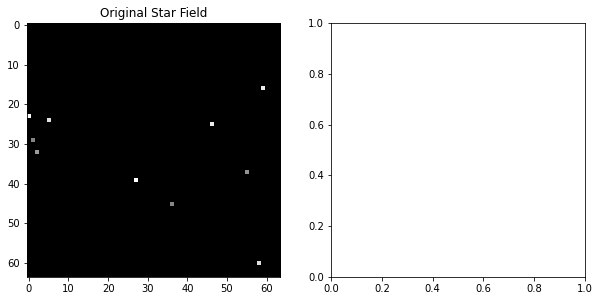

In [54]:
kersize = 15
psftest = gaussian_ker(kersize, 0, 3, 1)

kernels_test = np.zeros(star_field.shape + (kersize, kersize))
kernels_test[:,:] = psftest
image_blurred = spatially_variant_convolution(star_field, kernels_test)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(star_field, cmap='gray')
plt.title('Original Star Field')
plt.subplot(122)
plt.imshow(image_blurred, cmap='gray')
plt.title('Blurred Star Field')
plt.show()

In [ ]:
def params_to_cov():
    pass

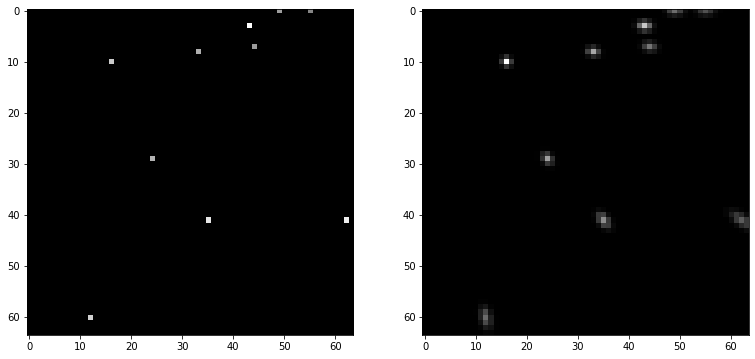

In [ ]:
def example_generate_variable_kernel(image_shape, kersize):
    img_h, img_w = image_shape
    kernels = np.zeros((img_h, img_w, kersize, kersize))

    for i in range(img_h):
        for j in range(img_w):
            angle = np.arctan2(i, j) + np.pi/2
            magnitude = 0.3*np.sqrt(i**2 + j**2)/img_h + 1
            eccentricity = (i**2 + j**2)/img_h**2 + 1
            kernels[i, j] = gaussian_ker(kersize, angle, magnitude, eccentricity)

    return kernels

# Generate the variable kernel
image_shape = star_field.shape
kersize = 15
variable_kernels = example_generate_variable_kernel(image_shape, kersize)


# Apply the spatially variant convolution
image_blurred_variable = spatially_variant_convolution(star_field, variable_kernels)

# Display the result
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.imshow(star_field, cmap='gray')
plt.subplot(122)
plt.imshow(image_blurred_variable, cmap='gray')
plt.show()

kriging sklearn gaussian process

wiener devrait marcher

clara:
wiener par patch
richardson lucy

Interpolateur de PSF (caractérisées par leurs matrices de cov)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.linalg import logm, expm

def interpolate_cov_field(known_positions, known_covariances, image_shape):
    """
    Interpolate Gaussian blur kernels across an image using Gaussian Process Regression.
    
    Parameters:
    - known_positions: array (n_samples, 2) coordinates of stars
    - known_covariances: array (n_samples, 2, 2) covariance at each star
    - image_shape: (height, width)
    
    Returns:
    - interpolated_covariances: array of shape (height, width, 2, 2)
    """
    # Convert covariance matrices to their matrix logarithm
    # This maps SPD matrices to the space of symmetric matrices
    log_covs = np.array([logm(cov) for cov in known_covariances])
    
    # Create target positions grid
    y, x = np.meshgrid(np.arange(image_shape[0]), np.arange(image_shape[1]), indexing='ij')
    target_positions = np.column_stack((y.ravel(), x.ravel()))
    
    # Define kernel with length scale related to image size
    length_scale = image_shape[0] #For now kernels are the same lengths as the image...
    kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=1e-5)
    #A FAIRE : peut être adapter le noise_level au bruit mesuré dans l'image
    
    # Fit GP for the entire matrix logarithm
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(known_positions, log_covs.reshape(len(known_positions), -1))
    
    # Predict and reshape back to covariance matrices
    log_predictions = gp.predict(target_positions)
    log_predictions = log_predictions.reshape(-1, 2, 2)
    
    # Convert back to covariance matrices using matrix exponential
    interpolated_covariances = np.array([expm(log_pred) for log_pred in log_predictions])
    
    # Reshape to image dimensions
    interpolated_covariances = interpolated_covariances.reshape(
        image_shape[0], image_shape[1], 2, 2)
    
    return interpolated_covariances

In [ ]:
# TEST de l'interpolation

def example2_generate_variable_kernel(image_shape, kersize):
    img_h, img_w = image_shape
    kernels = np.zeros((img_h, img_w, kersize, kersize))
    cov_variable = np.zeros((img_h, img_w, 2, 2))

    for i in range(img_h):
        for j in range(img_w):
            cov = np.zeros((2,2))
            cov[0,0] = (i**2 + j**2)/img_h**2 + 1
            cov[1,1] = 0.5*np.sqrt(i**2 + j**2)/img_h + 0.1
            cov[1,0] = 0.3*(i**2 + j**2)/img_h**2
            cov[0,1] = 0.3*(i**2 + j**2)/img_h**2
            cov_variable[i,j] = cov
            kernels[i, j] = gaussian_ker(kersize, cov=cov)

    return kernels, cov_variable #KEEP TRACK OF THE COVARIANCE MATRIX AT EACH POINT

kernels, covariances = example2_generate_variable_kernel(star_field.shape, 15)
blurred_starfield = spatially_variant_convolution(star_field, kernels)

known_positions = star_pos #shape (10,2)
known_covariances = np.array([covariances[tuple(pos)] for pos in known_positions]) #shape (10,2,2)

interpolated = interpolate_cov_field(known_positions, known_covariances, star_field.shape)

c:\Users\guezz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
diff = interpolated-covariances
errors = np.linalg.norm(diff, ord='fro', axis=(2,3))
errors.mean()

0.013017272185993045

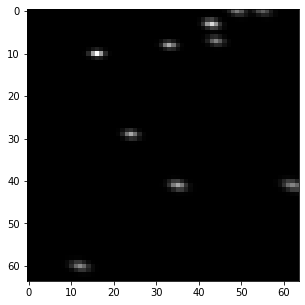

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(blurred_starfield, cmap='gray')

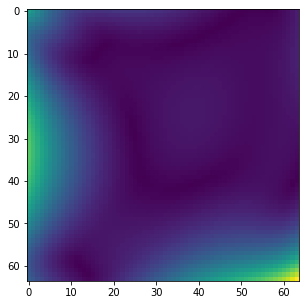

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(errors)

Code qui prend une image et trouve les positions des étoiles

In [55]:
from photutils.detection import DAOStarFinder, IRAFStarFinder

def detect_stars(image, threshold=0.99):
    """Detect star in an image using DAOStarFinder.
    
    Inputs :
    image : 2D array, the image.
    threshold : float, the threshold for detection.
    
    Returns :
    sources : Table, the detected stars
    """
    
    # Subtract the mean of the image
    mean = np.mean(image)
    image_subtracted = image - mean
    # Setup the DAOStarFinder with appropriate threshold and FWHM
    daofind = DAOStarFinder(threshold=threshold, fwhm=2, brightest=30) #3 because the image has been created with 3pixels FWHM
    sources = daofind.find_stars(image_subtracted)
    return sources

In [56]:
real_image = cv2.imread('D:/Ecole/Git_deconvolution_astro/astro_deconvo/original_images/PXL-4-cropped.jpg', cv2.IMREAD_GRAYSCALE)
real_image.shape

(725, 963)

In [57]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
import numpy as np

def detect_stars(image, threshold=0.99, method="DAO", fwhm=2, brightest=30):
    """
    Detect stars in an image using DAOStarFinder or IRAFStarFinder.
    
    Parameters:
    ----------
    image : 2D array
        The input image.
    threshold : float, optional
        The threshold for detection (default: 0.99).
    method : str, optional
        The method to use for star detection ("DAO" or "IRAF", default: "DAO").
    fwhm : float, optional
        Full width at half maximum of the stars (default: 2).
    brightest : int, optional
        Maximum number of brightest stars to detect (default: 30).
    
    Returns:
    -------
    detected_positions : ndarray
        Array of shape (n_stars, 2) containing (y, x) coordinates of detected stars.
    sources : Table
        The full table of detected stars with additional information.
    """
    # Subtract the mean of the image
    mean = np.mean(image)
    image_subtracted = image - mean
    
    # Choose the star finder method
    if method == "DAO":
        star_finder = DAOStarFinder(threshold=threshold, fwhm=fwhm, brightest=brightest)
    elif method == "IRAF":
        star_finder = IRAFStarFinder(threshold=threshold, fwhm=fwhm, brightest=brightest)
    else:
        raise ValueError("Invalid method. Choose 'DAO' or 'IRAF'.")
    
    # Detect stars
    sources = star_finder.find_stars(image_subtracted)
    
    # Extract (y, x) positions of detected stars
    if sources is not None:
        detected_positions = np.array([sources['ycentroid'], sources['xcentroid']]).T
    else:
        detected_positions = np.empty((0, 2))  # No stars detected
    
    return detected_positions, sources

code to vizalize comparison between the two methods

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_detected_stars(real_image, dao_positions, iraf_positions, output_path="detected_stars_comparison.png"):
    """
    Visualize the detected stars from DAOStarFinder and IRAFStarFinder on the original image.
    
    Parameters:
    ----------
    real_image : ndarray
        The original image.
    dao_positions : ndarray
        Array of shape (n_dao_stars, 2) with (y, x) coordinates of stars detected by DAOStarFinder.
    iraf_positions : ndarray
        Array of shape (n_iraf_stars, 2) with (y, x) coordinates of stars detected by IRAFStarFinder.
    output_path : str, optional
        Path to save the resulting image (default: "detected_stars_comparison.png").
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(real_image, cmap='gray', origin='lower')
    
    # Plot DAO detected stars in green
    for pos in dao_positions:
        circle = Circle((pos[1], pos[0]), radius=7, edgecolor='green', facecolor='none', lw=2, label='DAO Detected')
        ax.add_patch(circle)
    
    # Plot IRAF detected stars in red
    for pos in iraf_positions:
        circle = Circle((pos[1], pos[0]), radius=13, edgecolor='red', facecolor='none', lw=2, label='IRAF Detected')
        ax.add_patch(circle)
    
    # Add legend and labels
    handles = [
        Circle((0, 0), radius=7, edgecolor='green', facecolor='none', lw=2, label='DAO Detected'),
        Circle((0, 0), radius=13, edgecolor='red', facecolor='none', lw=2, label='IRAF Detected')
    ]
    ax.legend(handles=handles, loc='upper right')
    ax.set_title("Star Detection: DAO (Green) vs IRAF (Red)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    # Save the image
    plt.savefig(output_path, dpi=300)
    print(f"Image saved to {output_path}")
    plt.close(fig)

# Example usage

# Detect stars using DAOStarFinder
dao_positions, dao_sources = detect_stars(real_image, threshold=0.99, method="DAO")

# Detect stars using IRAFStarFinder
iraf_positions, iraf_sources = detect_stars(real_image, threshold=0.99, method="IRAF")

# Visualize and save the comparison
visualize_detected_stars(real_image, dao_positions, iraf_positions, output_path="detected_stars_comparison.png")

Image saved to detected_stars_comparison.png


We decided that DAO gives better results

Code qui prend une image, la liste des pos des étoiles et renvoie la liste des cov

In [58]:
def estimate_star_covariances(image, star_positions, patch_size=15):
    """
    Estimate the covariance matrices of gaussian blur for each detected star.
    
    Parameters:
    ----------
    image : 2D array
        The input image
    star_positions : ndarray
        Array of shape (n_stars, 2) containing (y, x) coordinates of detected stars
    patch_size : int
        Size of the patch around each star to analyze (should be odd)
    
    Returns:
    -------
    covariances : ndarray
        Array of shape (n_stars, 2, 2) containing the covariance matrix for each star
    """
    half_size = patch_size // 2
    covariances = []
    
    for pos in star_positions:
        y, x = int(pos[0]), int(pos[1])
        
        # Extract patch around the star
        patch = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        
        try:
            # Get covariance matrix from moments
            cov = estimate_gaussian_params(patch, cov=True)
            covariances.append(cov)
        except ValueError:
            # If estimation fails, append identity matrix
            covariances.append(np.eye(2))
    
    return np.array(covariances)

EVALUATION : MESURE DES COVARIANCES vs COVARIANCES REELES image simulée, ker variable

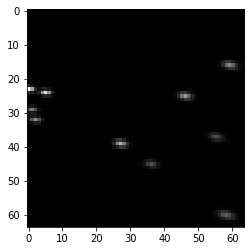

In [61]:
kernels, covariances = example2_generate_variable_kernel(star_field.shape, 15)
blurred_starfield = spatially_variant_convolution(star_field, kernels)

known_positions = star_pos #shape (10,2)
known_covariances = np.array([covariances[tuple(pos)] for pos in known_positions]) #shape (10,2,2)

plt.imshow(blurred_starfield, cmap='gray')

In [66]:
estimated_covariances = estimate_star_covariances(blurred_starfield, known_positions, patch_size=8)

In [70]:
estimated_covariances[0]

array([[9.66926688e-01, 3.88568022e+00, 1.71105006e+01, 8.08408422e+01],
       [3.87790278e+00, 1.57427258e+01, 6.99242652e+01, 3.32939270e+02],
       [1.60064234e+01, 6.56132034e+01, 2.93859599e+02, 1.40966897e+03],
       [6.78458259e+01, 2.80722394e+02, 1.26737775e+03, 6.12382557e+03]])

In [67]:
estimated_covariances.shape

(10, 4, 4)

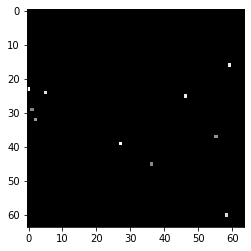

In [64]:
plt.imshow(star_field, cmap='gray')

EVALUATION : INTERPOLATION DES COVARIANCES à partir des COVARIANCES MESUREES image simulée, ker variable